# Sokoban RL Notebook

In [2]:
%cd ..
%ls
!pip install -r requirements.txt

c:\Users\canid\OneDrive\Masaüstü\Python\CS_175\sokobanRL\sokobanRL


c:\Users\canid\OneDrive\Masaüstü\Python\CS_175\sokobanRL\.venv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


 Volume in drive C is Windows
 Volume Serial Number is A45C-F748

 Directory of c:\Users\canid\OneDrive\Masa�st�\Python\CS_175\sokobanRL\sokobanRL

12/05/2025  02:57 PM    <DIR>          .
12/05/2025  02:15 PM    <DIR>          ..
12/03/2025  07:28 PM               952 check_import_by_can.py
12/05/2025  11:11 PM    <DIR>          checkpoints
12/05/2025  11:43 PM    <DIR>          logs
12/03/2025  06:25 PM                 8 README.md
12/05/2025  02:58 PM                86 requirements.txt
12/06/2025  11:07 AM    <DIR>          src
12/05/2025  02:08 PM    <DIR>          test
               3 File(s)          1,046 bytes
               6 Dir(s)  57,802,874,880 bytes free


In [ ]:
import gym
import gym_sokoban
import pygame
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import os

# NumPy 2.x compatibility patch
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_
print(f"NumPy version: {np.__version__}")
print("Compatibility patch applied ✓")

# Check if GPU is available
device = torch.device("cpu")
print(f"Using device: {device}")


# Reward Shaping Wrapper - STRONGER BONUSES for harder puzzles
class SokobanRewardShaper(gym.Wrapper):
    """
    Reward shaping wrapper using internal room_state for accurate tracking.
    STRONGER bonuses for harder Boxoban puzzles:
    - Reward for moving boxes closer to targets: +0.5 per unit (increased from 0.3)
    - Reward for placing box on target: +2.0 (increased from 1.0)
    - Penalty for moving boxes away from targets: -0.2 per unit
    """
    def __init__(self, env):
        super().__init__(env)
        self.previous_min_distance = None
        self.boxes_on_target = 0

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        self.previous_min_distance = self._compute_min_box_target_distance()
        self.boxes_on_target = self._count_boxes_on_target()
        return obs

    def _compute_min_box_target_distance(self):
        """Compute sum of minimum distances from each box to nearest target"""
        room = self.env.unwrapped.room_state

        # Find box positions (tile value 3 = box on target, 4 = box off target)
        boxes = np.argwhere((room == 3) | (room == 4))

        # Find target positions (tile value 2 = empty target, 3 = box on target)
        targets = np.argwhere((room == 2) | (room == 3))

        if len(boxes) == 0 or len(targets) == 0:
            return 0

        # Calculate sum of minimum Manhattan distances
        total_min_dist = 0
        for box in boxes:
            # Manhattan distance to each target
            distances = np.abs(targets - box).sum(axis=1)
            min_dist = distances.min()
            total_min_dist += min_dist

        return total_min_dist

    def _count_boxes_on_target(self):
        """Count boxes on target positions (tile value 3)"""
        room = self.env.unwrapped.room_state
        return np.sum(room == 3)

    def step(self, action):
        obs, reward, done, info = self.env.step(action)

        # Start with base reward
        shaped_reward = reward

        # STRONGER reward for moving boxes closer to targets
        current_min_distance = self._compute_min_box_target_distance()
        if self.previous_min_distance is not None:
            distance_change = self.previous_min_distance - current_min_distance
            if distance_change > 0:  # Moved closer
                shaped_reward += 0.5 * distance_change  # Increased from 0.3
            elif distance_change < 0:  # Moved away
                shaped_reward += 0.2 * distance_change  # Penalty

        self.previous_min_distance = current_min_distance

        # STRONGER reward for placing box on target
        current_boxes_on_target = self._count_boxes_on_target()
        if current_boxes_on_target > self.boxes_on_target:
            shaped_reward += 2.0 * (current_boxes_on_target - self.boxes_on_target)  # Increased from 1.0

        self.boxes_on_target = current_boxes_on_target

        return obs, shaped_reward, done, info

## Actor-Critic Network Architecture

In [14]:
class ActorCritic(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(ActorCritic, self).__init__()
        
        # Convolutional layers with Layer Normalization for stability
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=3, stride=2, padding=1)
        self.ln1 = nn.LayerNorm([32, input_shape[1]//2, input_shape[2]//2])
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.ln2 = nn.LayerNorm([64, input_shape[1]//4, input_shape[2]//4])
        
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.ln3 = nn.LayerNorm([64, input_shape[1]//8, input_shape[2]//8])
        
        conv_out_size = self._get_conv_out(input_shape)
        
        # Actor head (policy) with smaller hidden layer
        self.actor = nn.Sequential(
            nn.Linear(conv_out_size, 128),  # Reduced from 256
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )
        
        # Critic head (value function) with smaller hidden layer
        self.critic = nn.Sequential(
            nn.Linear(conv_out_size, 128),  # Reduced from 256
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
        # Orthogonal initialization for better gradient flow
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using orthogonal initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain=np.sqrt(2))
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=np.sqrt(2))
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def _get_conv_out(self, shape):
        o = self._forward_conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))
    
    def _forward_conv(self, x):
        """Forward pass through convolutional layers"""
        x = torch.relu(self.ln1(self.conv1(x)))
        x = torch.relu(self.ln2(self.conv2(x)))
        x = torch.relu(self.ln3(self.conv3(x)))
        return x
    
    def forward(self, x):
        conv_out = self._forward_conv(x).view(x.size()[0], -1)
        return self.actor(conv_out), self.critic(conv_out)
    
    def get_action_probs(self, x):
        logits, _ = self.forward(x)
        return torch.softmax(logits, dim=-1)
    
    def get_value(self, x):
        _, value = self.forward(x)
        return value

## PPO Agent

In [ ]:
class PPOAgent:
    def __init__(self, env, lr=3e-4, gamma=0.99, eps_clip=0.2, K_epochs=4, gae_lambda=0.95, 
                 entropy_coef=0.05, value_clip=0.2, warmup_steps=10, advantage_clip=10.0):
        self.env = env
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.gae_lambda = gae_lambda
        self.entropy_coef = entropy_coef
        self.value_clip = value_clip
        self.advantage_clip = advantage_clip
        
        # Learning rate warmup
        self.base_lr = lr
        self.warmup_steps = warmup_steps
        self.current_update = 0
        
        # Get observation shape
        obs = env.reset()
        if len(obs.shape) == 3:
            obs = np.transpose(obs, (2, 0, 1))
        
        self.input_shape = obs.shape
        self.n_actions = env.action_space.n
        
        self.device = torch.device("cpu")
        self.policy = ActorCritic(self.input_shape, self.n_actions).to(self.device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        
        self.policy_old = ActorCritic(self.input_shape, self.n_actions).to(self.device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()
    
    def _get_current_lr(self):
        """Get learning rate with warmup schedule"""
        if self.current_update < self.warmup_steps:
            # Linear warmup from 0 to base_lr
            return self.base_lr * (self.current_update + 1) / self.warmup_steps
        else:
            return self.base_lr
    
    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            action_probs = self.policy_old.get_action_probs(state)
        
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        
        return action.item(), action_logprob.item()
    
    def compute_gae(self, rewards, values, dones):
        advantages = []
        gae = 0
        
        for t in reversed(range(len(rewards))):
            if t == len(rewards) - 1:
                next_value = 0
            else:
                next_value = values[t + 1]
            
            delta = rewards[t] + self.gamma * next_value * (1 - dones[t]) - values[t]
            gae = delta + self.gamma * self.gae_lambda * (1 - dones[t]) * gae
            advantages.insert(0, gae)
        
        return advantages
    
    def update(self, memory):
        self.current_update += 1
        current_lr = self._get_current_lr()
        
        # Update learning rate
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = current_lr
        
        states = torch.FloatTensor(np.array(memory['states'])).to(self.device)
        actions = torch.LongTensor(memory['actions']).to(self.device)
        old_logprobs = torch.FloatTensor(memory['logprobs']).to(self.device)
        
        rewards = memory['rewards']
        dones = memory['dones']
        
        # Compute values and advantages
        with torch.no_grad():
            old_values = self.policy_old.get_value(states).squeeze().cpu().numpy()
        
        advantages = self.compute_gae(rewards, old_values, dones)
        advantages_tensor = torch.FloatTensor(advantages).to(self.device)
        
        # Store raw advantage statistics before clipping/normalization
        raw_adv_mean = advantages_tensor.mean().item()
        raw_adv_std = advantages_tensor.std().item()
        raw_adv_max = advantages_tensor.max().item()
        raw_adv_min = advantages_tensor.min().item()
        
        # CLIP advantages to prevent extreme values
        advantages_tensor = torch.clamp(advantages_tensor, -self.advantage_clip, self.advantage_clip)
        
        # Normalize advantages
        advantages_tensor = (advantages_tensor - advantages_tensor.mean()) / (advantages_tensor.std() + 1e-8)
        
        returns = advantages_tensor + torch.FloatTensor(old_values).to(self.device)
        old_values_tensor = torch.FloatTensor(old_values).to(self.device)
        
        # Optimize policy for K epochs
        total_grad_norm = 0.0
        for _ in range(self.K_epochs):
            logits, state_values = self.policy(states)
            dist = torch.distributions.Categorical(logits=logits)
            action_logprobs = dist.log_prob(actions)
            dist_entropy = dist.entropy()
            
            ratios = torch.exp(action_logprobs - old_logprobs)
            
            surr1 = ratios * advantages_tensor
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages_tensor
            
            actor_loss = -torch.min(surr1, surr2).mean()
            
            # Value function loss with clipping
            state_values_squeeze = state_values.squeeze()
            value_pred_clipped = old_values_tensor + torch.clamp(
                state_values_squeeze - old_values_tensor,
                -self.value_clip,
                self.value_clip
            )
            value_loss1 = self.MseLoss(state_values_squeeze, returns)
            value_loss2 = self.MseLoss(value_pred_clipped, returns)
            critic_loss = torch.max(value_loss1, value_loss2)
            
            entropy_loss = -self.entropy_coef * dist_entropy.mean()
            
            loss = actor_loss + 0.5 * critic_loss + entropy_loss
            
            self.optimizer.zero_grad()
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
            total_grad_norm += grad_norm.item()
            self.optimizer.step()
        
        avg_grad_norm = total_grad_norm / self.K_epochs
        
        # Calculate policy ratio statistics
        with torch.no_grad():
            final_logits, _ = self.policy(states)
            final_dist = torch.distributions.Categorical(logits=final_logits)
            final_logprobs = final_dist.log_prob(actions)
            final_ratios = torch.exp(final_logprobs - old_logprobs)
            
            ratio_mean = final_ratios.mean().item()
            ratio_std = final_ratios.std().item()
            ratio_max = final_ratios.max().item()
            ratio_min = final_ratios.min().item()
        
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        # Return comprehensive metrics
        metrics = {
            'actor_loss': actor_loss.item(),
            'critic_loss': critic_loss.item(),
            'entropy': -entropy_loss.item() / self.entropy_coef,
            'grad_norm': avg_grad_norm,
            'advantage_mean': raw_adv_mean,
            'advantage_std': raw_adv_std,
            'advantage_max': raw_adv_max,
            'advantage_min': raw_adv_min,
            'ratio_mean': ratio_mean,
            'ratio_std': ratio_std,
            'ratio_max': ratio_max,
            'ratio_min': ratio_min,
            'value_mean': np.mean(old_values),
            'value_std': np.std(old_values),
            'learning_rate': current_lr,
        }
        
        return metrics
    
    def save(self, path):
        torch.save(self.policy.state_dict(), path)
    
    def load(self, path):
        self.policy.load_state_dict(torch.load(path))
        self.policy_old.load_state_dict(torch.load(path))

## Training Loop

In [16]:
def train(env_name='Sokoban-v0', max_episodes=10000, max_timesteps=300, update_timestep=2048, save_freq=100):
    import datetime
    
    # Enable reward shaping for sparse reward exploration
    env = gym.make(env_name)
    env = SokobanRewardShaper(env)  # Enable reward shaping
    
    agent = PPOAgent(env)
    
    os.makedirs('checkpoints', exist_ok=True)
    os.makedirs('logs', exist_ok=True)
    
    # Create log file with timestamp
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    log_file = f'logs/training_log_{timestamp}.txt'
    
    # Write header to log file
    with open(log_file, 'w') as f:
        f.write("=" * 100 + "\n")
        f.write(f"SOKOBAN PPO TRAINING LOG (WITH REWARD SHAPING) - Started at {datetime.datetime.now()}\n")
        f.write("=" * 100 + "\n")
        f.write(f"Environment: {env_name} (WITH REWARD SHAPING)\n")
        f.write(f"Max Episodes: {max_episodes}\n")
        f.write(f"Max Timesteps per Episode: {max_timesteps}\n")
        f.write(f"Update Timestep: {update_timestep}\n")
        f.write(f"Save Frequency: {save_freq}\n")
        f.write("=" * 100 + "\n\n")
        f.write("HYPERPARAMETER IMPROVEMENTS + REWARD SHAPING:\n")
        f.write("1. REWARD SHAPING ENABLED: Intermediate rewards for box movements\n")
        f.write("   - +0.3 for each unit a box moves closer to targets\n")
        f.write("   - +1.0 for placing a box on a target\n")
        f.write("   - -0.2 for moving a box away from targets\n")
        f.write("2. Layer Normalization: Stabilizes network activations\n")
        f.write("3. Orthogonal Initialization: Better gradient flow\n")
        f.write("4. Value Function Clipping: Prevents critic divergence\n")
        f.write("5. Learning Rate Warmup: Gradual increase (10 updates)\n")
        f.write("6. Advantage Clipping: Prevents extreme advantage values\n")
        f.write("7. IMPROVED Hyperparameters:\n")
        f.write("   - lr=3e-4 (standard PPO learning rate)\n")
        f.write("   - entropy_coef=0.02 (exploration)\n")
        f.write("   - grad_clip=0.5 (stable gradients)\n")
        f.write("   - K_epochs=4\n")
        f.write("   - warmup_steps=10\n")
        f.write("=" * 100 + "\n\n")
        f.write("METRICS EXPLANATION:\n")
        f.write("- Episode: Episode number\n")
        f.write("- Reward: Total reward for this episode (WITH SHAPING BONUSES)\n")
        f.write("- Running Reward: Exponential moving average of rewards\n")
        f.write("- Steps: Number of steps taken in this episode\n")
        f.write("- Timestep: Total timesteps so far\n")
        f.write("- Actor Loss: Policy improvement metric\n")
        f.write("- Critic Loss: Value estimation error\n")
        f.write("- Entropy: Action randomness (target: 0.5-2.0)\n")
        f.write("- Grad Norm: Gradient magnitude\n")
        f.write("- Learning Rate: Current LR with warmup\n")
        f.write("- Ratio Mean: Policy change (should stay near 1.0)\n")
        f.write("=" * 100 + "\n\n")
        f.write("EXPECTED OUTCOMES:\n")
        f.write("- Episodes 1-50: Agent discovers box pushing rewards\n")
        f.write("- Episodes 50-150: Agent learns to push boxes toward targets\n")
        f.write("- Episodes 150-300: First successful box placements\n")
        f.write("- Episodes 300-500: Consistent success rate 20-40%\n")
        f.write("=" * 100 + "\n\n")
    
    print(f"Logging to: {log_file}\n")
    print("REWARD SHAPING ENABLED:")
    print("  - +0.3 per unit boxes move closer to targets")
    print("  - +1.0 for placing box on target")
    print("  - -0.2 per unit boxes move away from targets")
    print("\nIMPROVED HYPERPARAMETERS ACTIVE:")
    print("  - Layer normalization + Orthogonal init")
    print("  - Value function clipping + Advantage clipping (±10)")
    print("  - Learning rate warmup (10 updates)")
    print("  - lr=3e-4, entropy=0.02, grad_clip=0.5, K_epochs=4\n")
    
    episode_rewards = []
    episode_steps = []
    running_reward = 0
    timestep = 0
    
    # Track latest update metrics
    latest_metrics = None
    
    memory = {
        'states': [],
        'actions': [],
        'logprobs': [],
        'rewards': [],
        'dones': []
    }
    
    for episode in range(1, max_episodes + 1):
        state = env.reset()
        if len(state.shape) == 3:
            state = np.transpose(state, (2, 0, 1))
        
        episode_reward = 0
        
        for t in range(max_timesteps):
            timestep += 1
            
            action, action_logprob = agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            
            if len(next_state.shape) == 3:
                next_state = np.transpose(next_state, (2, 0, 1))
            
            memory['states'].append(state)
            memory['actions'].append(action)
            memory['logprobs'].append(action_logprob)
            memory['rewards'].append(reward)
            memory['dones'].append(done)
            
            state = next_state
            episode_reward += reward
            
            if timestep % update_timestep == 0:
                latest_metrics = agent.update(memory)
                memory = {
                    'states': [],
                    'actions': [],
                    'logprobs': [],
                    'rewards': [],
                    'dones': []
                }
                print(f"[UPDATE {agent.current_update}] Timestep {timestep} - "
                      f"LR: {latest_metrics['learning_rate']:.2e}, "
                      f"Actor: {latest_metrics['actor_loss']:.4f}, "
                      f"Critic: {latest_metrics['critic_loss']:.4f}, "
                      f"Entropy: {latest_metrics['entropy']:.4f}, "
                      f"GradNorm: {latest_metrics['grad_norm']:.4f}")
            
            if done:
                break
        
        episode_rewards.append(episode_reward)
        episode_steps.append(t + 1)
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward
        
        # Console output
        print(f"Episode {episode:5d} | Reward: {episode_reward:7.2f} | "
              f"Running: {running_reward:7.2f} | Steps: {t+1:3d}")
        
        # Write to log file after EVERY episode
        with open(log_file, 'a') as f:
            f.write(f"\n{'='*100}\n")
            f.write(f"EPISODE {episode} (Timestep: {timestep})\n")
            f.write(f"{'='*100}\n")
            f.write(f"  Reward:          {episode_reward:10.4f}\n")
            f.write(f"  Running Reward:  {running_reward:10.4f}\n")
            f.write(f"  Steps:           {t+1:10d}\n")
            f.write(f"  Total Timestep:  {timestep:10d}\n")
            
            # Add update metrics if available
            if latest_metrics is not None:
                f.write(f"\n  --- Latest Update Metrics (Update #{agent.current_update}) ---\n")
                f.write(f"  Learning Rate:   {latest_metrics['learning_rate']:10.8f}  (with warmup)\n")
                f.write(f"  Actor Loss:      {latest_metrics['actor_loss']:10.6f}\n")
                f.write(f"  Critic Loss:     {latest_metrics['critic_loss']:10.6f}\n")
                f.write(f"  Entropy:         {latest_metrics['entropy']:10.6f}\n")
                f.write(f"  Grad Norm:       {latest_metrics['grad_norm']:10.6f}\n")
                f.write(f"  \n")
                f.write(f"  Advantage Mean:  {latest_metrics['advantage_mean']:10.6f}\n")
                f.write(f"  Advantage Std:   {latest_metrics['advantage_std']:10.6f}\n")
                f.write(f"  Advantage Max:   {latest_metrics['advantage_max']:10.6f}\n")
                f.write(f"  Advantage Min:   {latest_metrics['advantage_min']:10.6f}\n")
                f.write(f"  \n")
                f.write(f"  Ratio Mean:      {latest_metrics['ratio_mean']:10.6f}\n")
                f.write(f"  Ratio Std:       {latest_metrics['ratio_std']:10.6f}\n")
                f.write(f"  Ratio Max:       {latest_metrics['ratio_max']:10.6f}\n")
                f.write(f"  Ratio Min:       {latest_metrics['ratio_min']:10.6f}\n")
                f.write(f"  \n")
                f.write(f"  Value Mean:      {latest_metrics['value_mean']:10.6f}\n")
                f.write(f"  Value Std:       {latest_metrics['value_std']:10.6f}\n")
        
        # Save checkpoints
        if episode % save_freq == 0:
            agent.save(f'checkpoints/ppo_sokoban_ep{episode}.pth')
            print(f"[CHECKPOINT] Model saved at episode {episode}")
            
            with open(log_file, 'a') as f:
                f.write(f"\n  >>> CHECKPOINT SAVED: checkpoints/ppo_sokoban_ep{episode}.pth\n")
    
    env.close()
    
    # Final summary
    with open(log_file, 'a') as f:
        f.write(f"\n\n{'='*100}\n")
        f.write(f"TRAINING COMPLETED - {datetime.datetime.now()}\n")
        f.write(f"{'='*100}\n")
        f.write(f"Total Episodes:       {max_episodes}\n")
        f.write(f"Total Timesteps:      {timestep}\n")
        f.write(f"Final Running Reward: {running_reward:.4f}\n")
        f.write(f"Best Episode Reward:  {max(episode_rewards):.4f} (Episode {episode_rewards.index(max(episode_rewards)) + 1})\n")
        f.write(f"Worst Episode Reward: {min(episode_rewards):.4f} (Episode {episode_rewards.index(min(episode_rewards)) + 1})\n")
        f.write(f"Average Reward:       {np.mean(episode_rewards):.4f}\n")
        f.write(f"Average Steps:        {np.mean(episode_steps):.2f}\n")
        f.write(f"{'='*100}\n")
    
    print(f"\nTraining complete! Log saved to: {log_file}")
    
    return episode_rewards

## Start Training

Run the cell below to start training. You can adjust the parameters:
- `max_episodes`: Total number of episodes to train
- `max_timesteps`: Maximum steps per episode
- `update_timestep`: How often to update the policy
- `save_freq`: How often to save checkpoints

In [ ]:
# Train on Sokoban-small-v0 (easier, smaller grid)
# Then gradually move to harder environments
episode_rewards = train(
    env_name='Sokoban-small-v0',
    max_episodes=10000,
    max_timesteps=150,  # Shorter episodes for smaller puzzles
    update_timestep=2048,
    save_freq=100
)

## Visualize Training Progress

NameError: name 'episode_rewards' is not defined

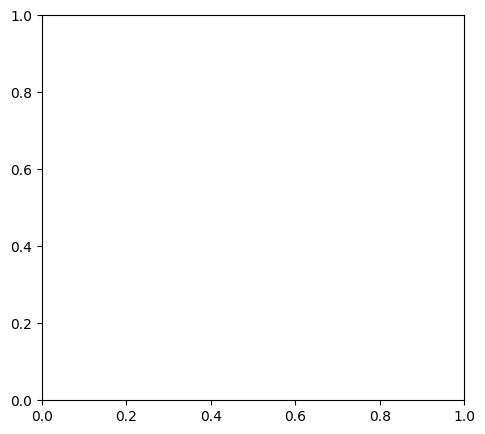

In [9]:
# Plot training rewards
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Episode Rewards')
plt.grid(True)

plt.subplot(1, 2, 2)
# Plot moving average
window_size = 100
if len(episode_rewards) >= window_size:
    moving_avg = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid')
    plt.plot(moving_avg)
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title(f'Moving Average (window={window_size})')
    plt.grid(True)

plt.tight_layout()
plt.show()

## Test Trained Agent

In [11]:
def test_agent(checkpoint_path, env_name='Boxoban-Val-v1', num_episodes=5, render=False):
    """
    Test a trained agent without reward shaping.
    
    Args:
        checkpoint_path: Path to the checkpoint file
        env_name: Environment to test on (default: Boxoban-Val-v1)
        num_episodes: Number of episodes to test
        render: Whether to render the environment
    
    Returns:
        List of episode rewards (base Sokoban rewards without shaping)
    """
    # Create environment WITHOUT reward shaping for true performance
    env = gym.make(env_name)
    agent = PPOAgent(env)
    agent.load(checkpoint_path)
    
    total_rewards = []
    
    print(f"Testing agent for {num_episodes} episodes on {env_name} (WITHOUT reward shaping)...\n")
    
    for episode in range(num_episodes):
        state = env.reset()
        if len(state.shape) == 3:
            state = np.transpose(state, (2, 0, 1))
        
        episode_reward = 0
        done = False
        steps = 0
        
        while not done and steps < 300:
            if render:
                env.render()
            
            action, _ = agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            
            if len(next_state.shape) == 3:
                next_state = np.transpose(next_state, (2, 0, 1))
            
            state = next_state
            episode_reward += reward
            steps += 1
        
        total_rewards.append(episode_reward)
        print(f"Test Episode {episode + 1:2d}: Reward = {episode_reward:7.2f}, Steps = {steps:3d}")
    
    env.close()
    print(f"\nAverage Reward: {np.mean(total_rewards):.2f}")
    return total_rewards

Loading checkpoint: checkpoints/ppo_sokoban_ep2500.pth


34047772it [00:41, 829889.43it/s]
c:\Users\canid\OneDrive\Masaüstü\Python\CS_175\sokobanRL\.venv\lib\site-packages\gym\utils\passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
c:\Users\canid\OneDrive\Masaüstü\Python\CS_175\sokobanRL\.venv\lib\site-packages\gym\utils\passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
c:\Users\canid\OneDrive\Masaüstü\Python\CS_175\sokobanRL\.venv\lib\site-packages\gym\utils\passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  log

Testing agent for 10 episodes on Boxoban-Val-v1 (WITHOUT reward shaping)...

Test Episode  1: Reward =  -20.00, Steps = 200
Test Episode  2: Reward =  -19.00, Steps = 200
Test Episode  3: Reward =  -20.00, Steps = 200
Test Episode  4: Reward =  -20.00, Steps = 200
Test Episode  5: Reward =  -20.00, Steps = 200
Test Episode  6: Reward =  -20.00, Steps = 200
Test Episode  7: Reward =  -20.00, Steps = 200
Test Episode  8: Reward =  -19.00, Steps = 200
Test Episode  9: Reward =  -20.00, Steps = 200
Test Episode 10: Reward =  -18.00, Steps = 200

Average Reward: -19.60

PERFORMANCE SUMMARY (on Boxoban validation levels)
Episodes tested: 10
Average reward: -19.60
Best reward: -18.00
Worst reward: -20.00
Std deviation: 0.66


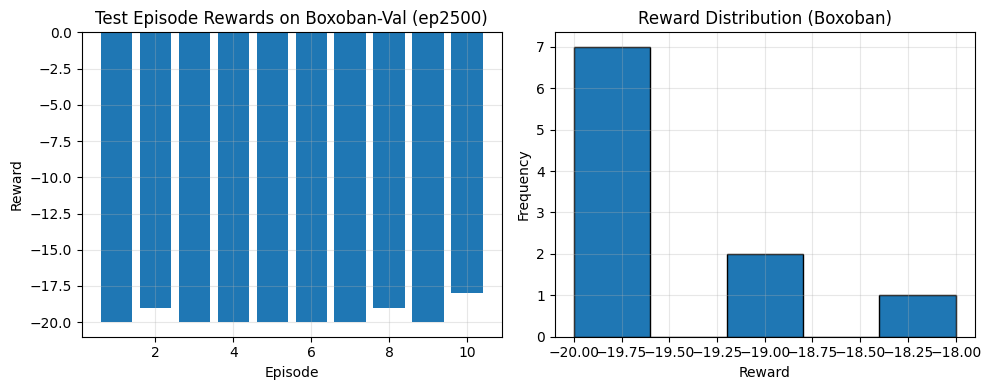

In [12]:
# Test the ep2500 checkpoint on Boxoban validation set
checkpoint_path = 'checkpoints/ppo_sokoban_ep2500.pth'

print(f"Loading checkpoint: {checkpoint_path}")
print("=" * 60)

# Test on Boxoban validation levels (harder than training levels)
test_rewards = test_agent(checkpoint_path, env_name='Boxoban-Val-v1', num_episodes=10, render=False)

print("\n" + "=" * 60)
print("PERFORMANCE SUMMARY (on Boxoban validation levels)")
print("=" * 60)
print(f"Episodes tested: 10")
print(f"Average reward: {np.mean(test_rewards):.2f}")
print(f"Best reward: {max(test_rewards):.2f}")
print(f"Worst reward: {min(test_rewards):.2f}")
print(f"Std deviation: {np.std(test_rewards):.2f}")
print("=" * 60)

# Show distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(range(1, 11), test_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Test Episode Rewards on Boxoban-Val (ep2500)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(test_rewards, bins=5, edgecolor='black')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.title('Reward Distribution (Boxoban)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()